# Compute change in temperature from ERF

This notebook takes the ERF dataset created in notebook 1 and computes the change in temperature from each forcing according to an impulse response function

### Imports


In [1]:
import pandas as pd
import xarray as xr
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR_BADC

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [2]:
from ar6_ch6_rcmipfigs.utils.badc_csv import read_csv_badc

In [3]:
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel, constants  # pip install openscm-twolayermodel
from openscm_units import unit_registry  # pip install openscm-units
from scmdata import ScmRun  # pip install scmdata

/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

### General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) from MAGICC?????? (#TODO: check model and reference), by integrating with the impulse response function (IRF(t-t'))

#todo: check for ref for IRF
(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:


\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below. 

**TODO: find ref**

## Input data:
See [README.md](../../README.md)

# Code + figures

In [4]:
fn_IRF_constants = INPUT_DATA_DIR_BADC /'recommended_irf_from_2xCO2_2021_02_25_222758.csv'

irf_consts = read_csv_badc(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,3.424102,285.003478,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [5]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1])
d2 = float(irf_consts[ld2])
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])
eff = float(irf_consts['efficacy (dimensionless)'])
print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=3.424102092311003, d2=285.0034778419114, q1=0.443767728883447, q2=0.3195910497425088


In [6]:

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=3.424102092311003, d2=285.0034778419114, q1=0.443767728883447, q2=0.3195910497425088


### Path input data

In [7]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'
PATH_DATASET_minor = OUTPUT_DATA_DIR / 'ERF_minorGHGs_data.nc'







## Path output data

In [8]:
PATH_DT_TAB_OUTPUT = RESULTS_DIR / 'tables' / 'table_sens_dT_cs_recommandetion.csv'
#PATH_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'
PATH_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation_minor.nc'

print(PATH_DT_OUTPUT)

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP_recommendation_minor.nc


## various definitions

In [9]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

## Set values:

We only compute for the recommendation (not e.g. percentiles):

In [10]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

Year to integrate from and to:

In [11]:
first_y = 1750
last_y = 2100

**Set reference year for temperature change:**

In [12]:
ref_year = 2019

**Years to output change in**

In [13]:
years = [2040, 2100]

### Define variables to look at:

In [14]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-radiation_interactions',
    'aerosol-cloud_interactions',
    'aerosol-total',
    'o3',
    'HFCs',
    # 'F-Gases|HFC',
    'bc_on_snow',
    'total_anthropogenic',
    'total',
]
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = ['ssp534-over', 'ssp119', 'ssp334','ssp460', 'ssp585', 'ssp370',
                'ssp370-lowNTCF-aerchemmip', 'ssp126', 'ssp245', 'ssp434',
                'ssp370-lowNTCF-gidden'
                ]

## IRF function: 

In [15]:

def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

### Open ERF dataset:

In [16]:
ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
da_ERF = ds['ERF']

In [17]:
ds_minor = xr.open_dataset(PATH_DATASET_minor).sel(year=slice(1700, 2200))  # we need only years until 1700
da_ERF_minor = ds['ERF']

In [18]:
da_ERF_minor.sel(variable='HFCs').isel(scenario=1)

<xarray.DataArray 'ERF' (year: 451)>
array([0.      , 0.      , 0.      , ..., 0.131023, 0.129437, 0.12785 ])
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2196 2197 2198 2199 2200
    variable  <U4 'HFCs'
    scenario  <U6 'ssp370'

#### Simple pre-processing

In [19]:
ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')
ds_minor['time'] = pd.to_datetime(ds_minor['year'].to_pandas().index.map(str), format='%Y')

# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})
ds_minor['delta_t'] = xr.DataArray(np.ones(len(ds_minor['year'])), dims='year', coords={'year': ds['year']})

## Integrate and compute $\Delta T$:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [20]:


def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2]
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    #fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    #ds_DT.to_netcdf(fname)
    return ds_DT

In [21]:
int(ds.isel(year=0)['year'].values)

1750

In [22]:
def calc_dGSAT(var, ds, ds_out, scenario='scenario'):
    s_y = int(ds.isel(year=0)['year'].values)
    _erf_tmp = ds['ERF'].sel(variable=var).to_pandas()
    unit = "W/m^2"

    driver = ScmRun(

        data=_erf_tmp,
        index=s_y + np.arange(len(_erf_tmp)),
        columns={
            "unit": unit,
            "model": "custom",
            "scenario": scenario,
            "region": "World",
            "variable": "Effective Radiative Forcing",
        },
    )

    impulse_res = ImpulseResponseModel(
        d1=d1 * unit_registry("yr"),
        d2=d2 * unit_registry("yr"),
        q1=q1* unit_registry("delta_degC / (W / m^2)"),
        q2=q2* unit_registry("delta_degC / (W / m^2)"),
        efficacy=eff* unit_registry("dimensionless"),
    )
    dt_tmp = impulse_res.run_scenarios(driver)


    df_tmp= dt_tmp.filter(variable='Surface Temperature').timeseries()#.lineplot()#['Surface']
    #_ds_dT[var] =df_tmp.transpose()

    #ds_out[var]  =
    df_tmp = df_tmp.reset_index().iloc[:,12:].transpose().rename({0:var}, axis=1)#.to_xarray()
    year_index = pd.to_datetime(df_tmp.index).year
    df_tmp['year'] = year_index
    df_tmp = df_tmp.set_index('year')

    ds_out[var] = df_tmp.to_xarray()[var]

    return ds_out

In [23]:
def calc_GSAT_all_vars(_ds, ds_out, variables=None, scenario='scenario'):


    if variables is None:
        variables =_ds['variable'].values


    _ds_dT = xr.Dataset()
    for var in variables:
        print(var)
        _ds_dT = calc_dGSAT(var, _ds, _ds_dT, scenario=scenario)
        print()
    ds_DT = _ds_dT.to_array(name=name_deltaT)

    #ds_out[name_deltaT] = ds_DT


    return ds_DT

In [24]:
def calc_GSAT_all_scenarios(ds, ds_out, scenarios_l = None):


    scenarios_l = None
    if scenarios_l is None:
        scenarios_l = ds[scenario].values
    _ds_dT = xr.Dataset()
    _ds_out = xr.Dataset()
    for scn in scenarios_l:
        print(scn)
        ds_scn = calc_GSAT_all_vars(ds.sel(scenario = scn), _ds_dT, scenario=scn)
        ds_scn = ds_scn.rename(scn)
        _ds_out[scn] = ds_scn
    ds_DT = _ds_out.to_array(dim=scenario, name=name_deltaT)
    ds_out[name_deltaT] = ds_DT


    return ds_out

In [25]:
ds_minor

<xarray.Dataset>
Dimensions:   (year: 451, variable: 50, scenario: 11)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2196 2197 2198 2199 2200
  * variable  (variable) object 'HFC-134a' 'HFC-23' ... 'HCFC-124' 'HFCs'
  * scenario  (scenario) object 'ssp126' 'ssp245' 'ssp585' ... 'ssp334' 'ssp119'
Data variables:
    ERF       (scenario, variable, year) float64 ...
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2200-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

In [26]:
dic_minor_ds_old = {}
for key in IRFpercentiles:
    dic_minor_ds_old[key] = integrate_to_dT(ds_minor, first_y, last_y, irf_consts.loc[key], int_var='ERF')

In [27]:
dic_minor_ds = {}
ds_out = ds_minor.copy(deep=True)
for key in IRFpercentiles:
    dic_minor_ds[key] = calc_GSAT_all_scenarios(ds_minor,ds_out)

ssp126
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:147: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only
  out.index = out.index.set_levels([unit], "unit")
/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:148: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only
  out.index = out.index.set_levels([variable], "variable")


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp245
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp585
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp460
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp370
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp370-lowNTCF-aerchemmip
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp434
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp534-over
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp370-lowNTCF-gidden
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp334
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]


ssp119
HFC-134a


scenarios: 0it [00:00, ?it/s]


HFC-23


scenarios: 0it [00:00, ?it/s]


HFC-32


scenarios: 0it [00:00, ?it/s]


HFC-125


scenarios: 0it [00:00, ?it/s]


HFC-143a


scenarios: 0it [00:00, ?it/s]


HFC-152a


scenarios: 0it [00:00, ?it/s]


HFC-227ea


scenarios: 0it [00:00, ?it/s]


HFC-236fa


scenarios: 0it [00:00, ?it/s]


HFC-245fa


scenarios: 0it [00:00, ?it/s]


HFC-365mfc


scenarios: 0it [00:00, ?it/s]


HFC-43-10mee


scenarios: 0it [00:00, ?it/s]


NF3


scenarios: 0it [00:00, ?it/s]


SF6


scenarios: 0it [00:00, ?it/s]


SO2F2


scenarios: 0it [00:00, ?it/s]


CF4


scenarios: 0it [00:00, ?it/s]


C2F6


scenarios: 0it [00:00, ?it/s]


C3F8


scenarios: 0it [00:00, ?it/s]


c-C4F8


scenarios: 0it [00:00, ?it/s]


CFC-12


scenarios: 0it [00:00, ?it/s]


CFC-11


scenarios: 0it [00:00, ?it/s]


CFC-113


scenarios: 0it [00:00, ?it/s]


CFC-114


scenarios: 0it [00:00, ?it/s]


CFC-115


scenarios: 0it [00:00, ?it/s]


CFC-13


scenarios: 0it [00:00, ?it/s]


HCFC-22


scenarios: 0it [00:00, ?it/s]


HCFC-141b


scenarios: 0it [00:00, ?it/s]


HCFC-142b


scenarios: 0it [00:00, ?it/s]


CH3CCl3


scenarios: 0it [00:00, ?it/s]


CCl4


scenarios: 0it [00:00, ?it/s]


CH3Cl


scenarios: 0it [00:00, ?it/s]


CH3Br


scenarios: 0it [00:00, ?it/s]


CH2Cl2


scenarios: 0it [00:00, ?it/s]


CHCl3


scenarios: 0it [00:00, ?it/s]


Halon-1211


scenarios: 0it [00:00, ?it/s]


Halon-1301


scenarios: 0it [00:00, ?it/s]


Halon-2402


scenarios: 0it [00:00, ?it/s]


n-C4F10


scenarios: 0it [00:00, ?it/s]


n-C5F12


scenarios: 0it [00:00, ?it/s]


n-C6F14


scenarios: 0it [00:00, ?it/s]


i-C6F14


scenarios: 0it [00:00, ?it/s]


C7F16


scenarios: 0it [00:00, ?it/s]


C8F18


scenarios: 0it [00:00, ?it/s]


CFC-112


scenarios: 0it [00:00, ?it/s]


CFC-112a


scenarios: 0it [00:00, ?it/s]


CFC-113a


scenarios: 0it [00:00, ?it/s]


CFC-114a


scenarios: 0it [00:00, ?it/s]


HCFC-133a


scenarios: 0it [00:00, ?it/s]


HCFC-31


scenarios: 0it [00:00, ?it/s]


HCFC-124


scenarios: 0it [00:00, ?it/s]


HFCs


scenarios: 0it [00:00, ?it/s]

## check:

In [28]:
_ds_minor = dic_minor_ds['recommendation']
_ds_minor['variable'].values

array(['HFC-134a', 'HFC-23', 'HFC-32', 'HFC-125', 'HFC-143a', 'HFC-152a',
       'HFC-227ea', 'HFC-236fa', 'HFC-245fa', 'HFC-365mfc',
       'HFC-43-10mee', 'NF3', 'SF6', 'SO2F2', 'CF4', 'C2F6', 'C3F8',
       'c-C4F8', 'CFC-12', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115',
       'CFC-13', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CH3CCl3', 'CCl4',
       'CH3Cl', 'CH3Br', 'CH2Cl2', 'CHCl3', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'n-C4F10', 'n-C5F12', 'n-C6F14', 'i-C6F14', 'C7F16',
       'C8F18', 'CFC-112', 'CFC-112a', 'CFC-113a', 'CFC-114a',
       'HCFC-133a', 'HCFC-31', 'HCFC-124', 'HFCs'], dtype='<U12')

In [29]:
ls = list(ds_minor['variable'].values)
# chocose only those with HFC in them
vars_HFCs = [v for v in ls if 'HFC' in v]

vars_HFCs

['HFC-134a',
 'HFC-23',
 'HFC-32',
 'HFC-125',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-43-10mee',
 'HFCs']

In [30]:
len(vars_HFCs)

12

In [31]:
ordered_lifetime_ls = [
'HFC-152a',
'HFC-32',
'HFC-245fa',
'HFC-365mfc',
'HFC-134a',
'HFC-43-10mee',
'HFC-125',
'HFC-227ea',
'HFC-143a',
'HFC-236fa',
'HFC-23',
]

In [32]:
hfcs_tau = {
'HFC-152a':1.6,
'HFC-32':5.4,
'HFC-245fa':7.9,
'HFC-365mfc':8.9,
'HFC-134a':14.0,
'HFC-43-10mee':17.0,
'HFC-125':30.0,
'HFC-227ea':36.0,
'HFC-143a':51.0 ,
'HFC-236fa':213.0,
'HFC-23':228,
}

In [33]:
ordered_lifetime_ls[:0]

[]

In [34]:
import numpy as np

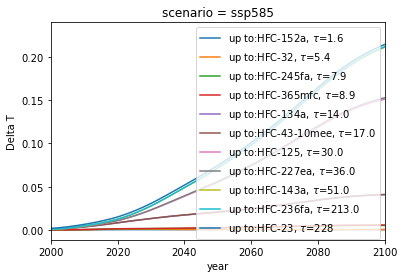

In [35]:
for i in np.arange(len(ordered_lifetime_ls)):
    _tmp = _ds_minor[name_deltaT].sel(variable=ordered_lifetime_ls[0:(i+1)])
    _tmp.sel(scenario='ssp585').sum('variable').plot(label=f'up to:{ordered_lifetime_ls[i]}, $\\tau$={hfcs_tau[ordered_lifetime_ls[i]]}')
plt.xlim([2000,2100])
plt.legend()
plt.show()

In [36]:
ordered_lifetime_ls

['HFC-152a',
 'HFC-32',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-134a',
 'HFC-43-10mee',
 'HFC-125',
 'HFC-227ea',
 'HFC-143a',
 'HFC-236fa',
 'HFC-23']

In [37]:
rn_dic = {}
for v in ordered_lifetime_ls:
    tau = hfcs_tau[v]
    
    rn_dic[v]=f'{v}, $\\tau$={tau}'

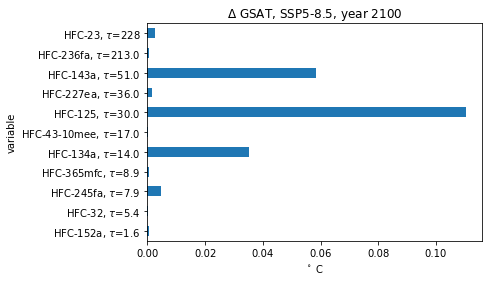

In [38]:
_tmp = _ds_minor[name_deltaT].sel(scenario='ssp585',year=2100, variable=ordered_lifetime_ls)#\.plot()
_tmp.to_pandas().rename(rn_dic).plot.barh()
plt.title('$\Delta$ GSAT, SSP5-8.5, year 2100')
plt.xlabel('$^\circ$ C')
plt.show()

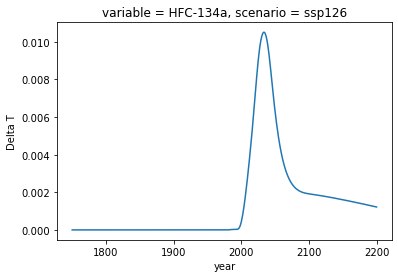

In [39]:
for per in IRFpercentiles:
    dic_minor_ds[per].isel(scenario=0, variable=0)[name_deltaT].plot()
plt.show()

### Make datset with percentile as dimension:
Does really only make sense with percentiles...

ds_tmp = xr.Dataset(coords=dic_ds[recommendation].coords)
ds_tmp
for key in IRFpercentiles:
    ds_tmp[key] = dic_ds[key]['Delta T']  # .dims,dic_ds[key],)
ds['Delta T'] = ds_tmp.to_array('percentile')

In [40]:
ds_tmp = xr.Dataset(coords=dic_minor_ds[recommendation].coords)
ds_tmp
for key in IRFpercentiles:
    ds_tmp[key] = dic_minor_ds[key]['Delta T']  # .dims,dic_ds[key],)
ds_minor['Delta T'] = ds_tmp.to_array('percentile')

# Save dataset:

In [41]:
ds_minor['Delta T'].year

<xarray.DataArray 'year' (year: 451)>
array([1750, 1751, 1752, ..., 2198, 2199, 2200])
Coordinates:
  * year     (year) int64 1750 1751 1752 1753 1754 ... 2196 2197 2198 2199 2200

In [42]:
ds_minor.sel(year=slice(first_y, last_y)).to_netcdf(PATH_DT_OUTPUT)
print(f'Saved to {PATH_DT_OUTPUT}')
# ds_DT.to_array('percentile')
# dic_ds[key]['Delta T']

Saved to /Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP_recommendation_minor.nc
